In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import SMOTE
!pip install shap
import shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 9.8 MB/s eta 0:00:00


In [ ]:
# Cargamos el conjunto de datos
df = pd.read_csv('Heart_Attack.csv')
df

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative
...,...,...,...,...,...,...,...,...,...
1314,44,1,94,122,67,204.0,1.63,0.006,negative
1315,66,1,84,125,55,149.0,1.33,0.172,positive
1316,45,1,85,168,104,96.0,1.24,4.250,positive
1317,54,1,58,117,68,443.0,5.80,0.359,positive


In [ ]:
# Checkeamos los tipos de las variables
df.dtypes

age                int64
gender             int64
impluse            int64
pressurehight      int64
pressurelow        int64
glucose          float64
kcm              float64
troponin         float64
class             object
dtype: object

In [ ]:
# Convertimos la clase a 0 y 1 en lugar de negative y positive

df['class'] = df['class'].map({'negative': 0, 'positive': 1})
df

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64,1,66,160,83,160.0,1.80,0.012,0
1,21,1,94,98,46,296.0,6.75,1.060,1
2,55,1,64,160,77,270.0,1.99,0.003,0
3,64,1,70,120,55,270.0,13.87,0.122,1
4,55,1,64,112,65,300.0,1.08,0.003,0
...,...,...,...,...,...,...,...,...,...
1314,44,1,94,122,67,204.0,1.63,0.006,0
1315,66,1,84,125,55,149.0,1.33,0.172,1
1316,45,1,85,168,104,96.0,1.24,4.250,1
1317,54,1,58,117,68,443.0,5.80,0.359,1


In [ ]:
# Checkeamos que no hay valores nulos en alguna celda
df.isna().sum()

age              0
gender           0
impluse          0
pressurehight    0
pressurelow      0
glucose          0
kcm              0
troponin         0
class            0
dtype: int64

## Análisis

Primero empezamos mirando las correlaciones entre variables

In [ ]:
# Checkeamos las correlaciones entre variables
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

NameError: ignored

Solamente `age`, `kcm` y `troponin` presentan una correlación relativamente alta con la clase. Esto tiene lógica.

A continuación, miramos los p-valores.

In [ ]:
# Tabla de los p-valores. No sé si está bien

results = []
for col in df.columns:
    X = sm.add_constant(df[col])  # Agrega una constante (intercepto)
    y = df['class']

    model = sm.OLS(y, X).fit()
    p_value = model.pvalues[col]

    results.append({'Variable': col, 'P-Value': p_value})

# Crea un DataFrame con los resultados
p_value_table = pd.DataFrame(results)
p_value_table

,Variable,P-Value
0,age,1.861645e-18
1,gender,5.946979e-04
2,impluse,8.017343e-01
3,pressurehight,4.498359e-01
4,pressurelow,7.259839e-01
5,glucose,2.302000e-01
6,kcm,1.287762e-15
7,troponin,3.303209e-17
8,class,0.000000e+00


In [ ]:
# Contar cuántos ejemplos hay de cada clase

class_counts = df['class'].value_counts()
print(class_counts)
total_samples = len(df)

class_percentages = class_counts / total_samples * 100
class_percentages

1    810
0    509
Name: class, dtype: int64


1    61.410159
0    38.589841
Name: class, dtype: float64

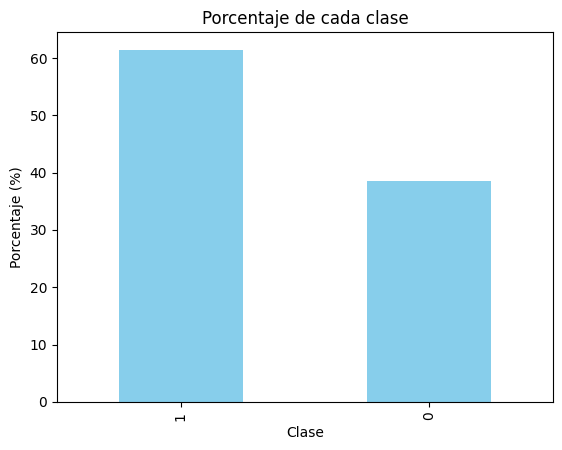

In [ ]:
# Visualización de la cantidad de datos pertenecientes a cada clase

class_percentages.plot(kind='bar', color='skyblue')
plt.xlabel('Clase')
plt.ylabel('Porcentaje (%)')
plt.title('Porcentaje de cada clase')
plt.show()

Estudiamos las distribuciones de las variables

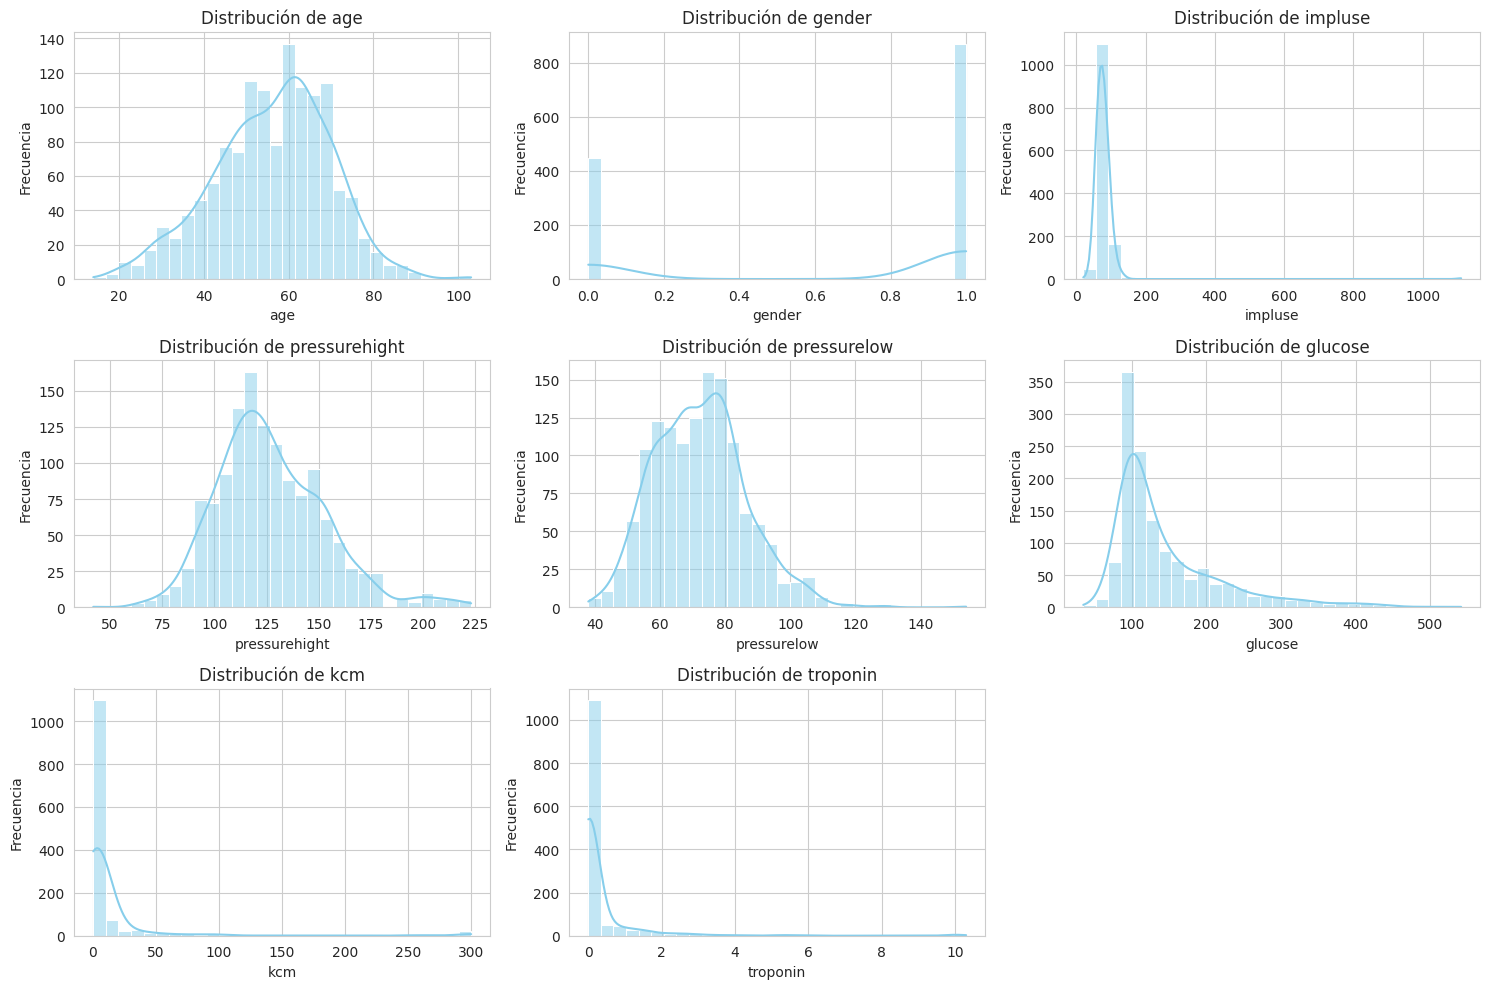

                count        mean        std     min      25%      50%  \
age            1319.0   56.191812  13.647315  14.000   47.000   58.000   
gender         1319.0    0.659591   0.474027   0.000    0.000    1.000   
impluse        1319.0   78.336619  51.630270  20.000   64.000   74.000   
pressurehight  1319.0  127.170584  26.122720  42.000  110.000  124.000   
pressurelow    1319.0   72.269143  14.033924  38.000   62.000   72.000   
glucose        1319.0  146.634344  74.923045  35.000   98.000  116.000   
kcm            1319.0   15.274306  46.327083   0.321    1.655    2.850   
troponin       1319.0    0.360942   1.154568   0.001    0.006    0.014   

                    75%     max  
age             65.0000   103.0  
gender           1.0000     1.0  
impluse         85.0000  1111.0  
pressurehight  143.0000   223.0  
pressurelow     81.0000   154.0  
glucose        169.5000   541.0  
kcm              5.8050   300.0  
troponin         0.0855    10.3  

Valores Atípicos:
age     

In [ ]:
# Establecemos el estilo de Seaborn para mejorar la estética de los gráficos
sns.set_style("whitegrid")

# 2. Estudiar la distribución de cada variable
predictors = ['age', 'gender', 'impluse', 'pressurehight', 'pressurelow', 'glucose', 'kcm', 'troponin']

# Histogramas para las variables predictoras
plt.figure(figsize=(15, 10))
for i, predictor in enumerate(predictors, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[predictor], bins=30, kde=True, color='skyblue')
    plt.title(f'Distribución de {predictor}')
    plt.xlabel(predictor)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Estadísticas descriptivas para las variables predictoras
print(df[predictors].describe().T)  # Transponemos para una mejor visualización

# 3. Identificar valores atípicos (usaremos el método IQR)
Q1 = df[predictors].quantile(0.25)
Q3 = df[predictors].quantile(0.75)
IQR = Q3 - Q1

# Definir un dataframe booleano donde TRUE indica un valor atípico
outliers = ((df[predictors] < (Q1 - 1.5 * IQR)) | (df[predictors] > (Q3 + 1.5 * IQR)))

print("\nValores Atípicos:")
print(outliers.sum())

# 4. Verificar la existencia de valores faltantes
print("\nValores Faltantes:")
print(df[predictors].isnull().sum())

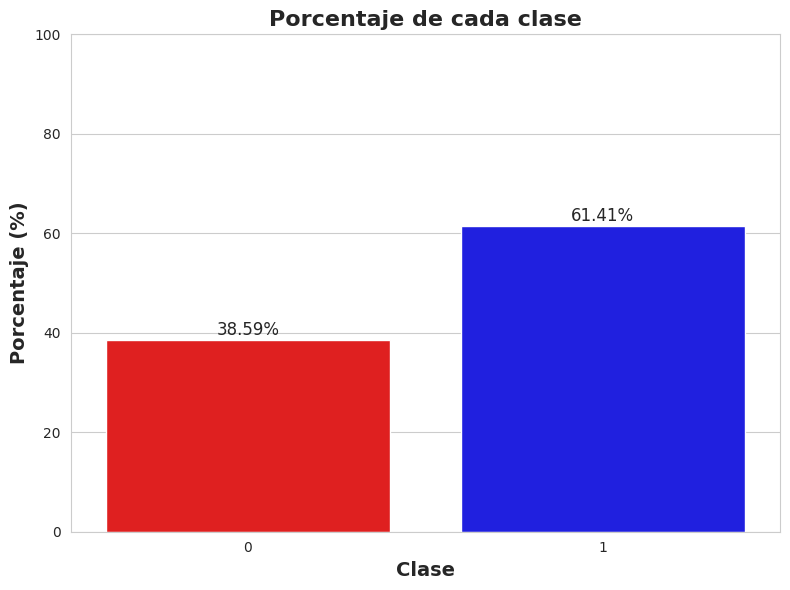

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer estilo de Seaborn
sns.set_style("whitegrid")

# Crear una figura y eje
fig, ax = plt.subplots(figsize=(8, 6))

# Definir paleta de colores con rojo y azul
colors = ["red", "blue"]

# Dibujar gráfico de barras con Seaborn
sns.barplot(x=class_percentages.index, y=class_percentages.values, palette=colors, ax=ax)

# Establecer etiquetas, título y personalizar eje y
ax.set_xlabel('Clase', fontsize=14, fontweight='bold')
ax.set_ylabel('Porcentaje (%)', fontsize=14, fontweight='bold')
ax.set_title('Porcentaje de cada clase', fontsize=16, fontweight='bold')
ax.set_ylim(0, 100)  # Establecer límites para el eje y

# Mostrar los porcentajes exactos en cada barra
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.2f}%', (x + width/2, y + height + 1), ha='center', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Quitar valores atíìcos y evaluamos el rendimiento con y sin ellos.

In [ ]:
predictores = list(df.columns[:-1])
X = df[predictores]
y = df[['class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf_all_data = RandomForestClassifier()

clf_all_data.fit(X_train, y_train.values.ravel())

# Entrenamiento con todos los datos
clf_all_data = RandomForestClassifier()
clf_all_data.fit(X_train, y_train.values.ravel())  # Corrección aquí
y_pred = clf_all_data.predict(X_test)
accuracy_all_data = accuracy_score(y_test, y_pred)

# Identificar y eliminar valores atípicos usando IQR
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1
X_train_no_outliers = X_train[~((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).any(axis=1)]

# Assumption: y_train is a pandas DataFrame. If it's not, this line needs to be adapted.
y_train_no_outliers = y_train.loc[X_train_no_outliers.index]

# Entrenamiento sin valores atípicos
clf_no_outliers = RandomForestClassifier()
clf_no_outliers.fit(X_train_no_outliers, y_train_no_outliers.values.ravel())  # Corrección aquí si y_train es un DataFrame
y_pred_no_outliers = clf_no_outliers.predict(X_test)
accuracy_no_outliers = accuracy_score(y_test, y_pred_no_outliers)

# Comparación
print(f"Accuracy con todos los datos: {accuracy_all_data}")
print(f"Accuracy sin valores atípicos: {accuracy_no_outliers}")

Accuracy con todos los datos: 0.9810606060606061
Accuracy sin valores atípicos: 0.9772727272727273


Aplicamos SMOTE para el balanceo de clases.

Objetivo del modelo: Si es esencial minimizar los falsos negativos (por ejemplo, decir que no hay un ataque al corazón cuando sí lo hay), entonces podría ser útil balancear las clases para que el modelo no esté sesgado hacia la clase mayoritaria.



In [ ]:
# Resample para balancear clases.

X = df[predictors]  # Variables predictoras
y = df['class']     # Variable objetivo

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df = pd.concat([X_resampled, y_resampled.to_frame("class")], axis=1)

df

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64,1,66,160,83,160.000000,1.800000,0.012000,0
1,21,1,94,98,46,296.000000,6.750000,1.060000,1
2,55,1,64,160,77,270.000000,1.990000,0.003000,0
3,64,1,70,120,55,270.000000,13.870000,0.122000,1
4,55,1,64,112,65,300.000000,1.080000,0.003000,0
...,...,...,...,...,...,...,...,...,...
1615,33,1,58,125,69,123.458005,1.905094,0.003243,0
1616,29,0,110,169,103,69.031722,1.392841,0.005859,0
1617,47,0,91,123,70,203.462655,2.046442,0.007343,0
1618,55,1,92,71,92,126.600675,1.845257,0.008978,0


In [ ]:
df_no_parametrico = df.copy()

del_columns = ["impluse", "pressurehight", "pressurelow", "glucose"]
df_no_parametrico.drop(del_columns, axis=1, inplace=True)

df_no_parametrico

,age,gender,kcm,troponin,class
0,64,1,1.800000,0.012000,0
1,21,1,6.750000,1.060000,1
2,55,1,1.990000,0.003000,0
3,64,1,13.870000,0.122000,1
4,55,1,1.080000,0.003000,0
...,...,...,...,...,...
1615,33,1,1.905094,0.003243,0
1616,29,0,1.392841,0.005859,0
1617,47,0,2.046442,0.007343,0
1618,55,1,1.845257,0.008978,0


In [ ]:
# Tabla de los p-valores. No sé si está bien

results = []
for col in df_no_parametrico.columns:
    X = sm.add_constant(df_no_parametrico[col])  # Agrega una constante (intercepto)
    y = df_no_parametrico['class']

    model = sm.OLS(y, X).fit()
    p_value = model.pvalues[col]

    results.append({'Variable': col, 'P-Value': p_value})

# Crea un DataFrame con los resultados
p_value_table = pd.DataFrame(results)
p_value_table

,Variable,P-Value
0,age,2.985155e-25
1,gender,7.314583e-15
2,kcm,8.678068e-24
3,troponin,6.246656e-27
4,class,0.000000e+00


In [ ]:
# Contar cuántos ejemplos hay de cada clase

class_counts = df['class'].value_counts()
print(class_counts)
total_samples = len(df)

class_percentages = class_counts / total_samples * 100
class_percentages

0    810
1    810
Name: class, dtype: int64


0    50.0
1    50.0
Name: class, dtype: float64

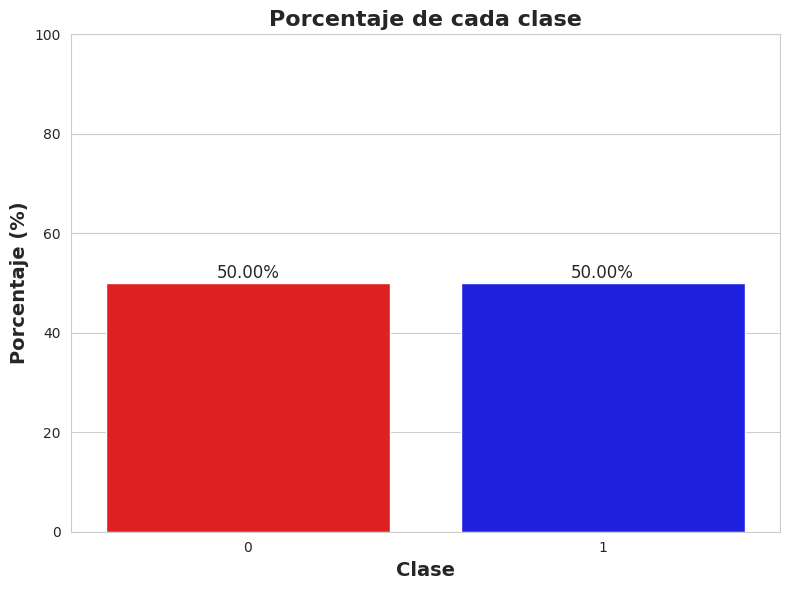

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer estilo de Seaborn
sns.set_style("whitegrid")

# Crear una figura y eje
fig, ax = plt.subplots(figsize=(8, 6))

# Definir paleta de colores con rojo y azul
colors = ["red", "blue"]

# Dibujar gráfico de barras con Seaborn
sns.barplot(x=class_percentages.index, y=class_percentages.values, palette=colors, ax=ax)

# Establecer etiquetas, título y personalizar eje y
ax.set_xlabel('Clase', fontsize=14, fontweight='bold')
ax.set_ylabel('Porcentaje (%)', fontsize=14, fontweight='bold')
ax.set_title('Porcentaje de cada clase', fontsize=16, fontweight='bold')
ax.set_ylim(0, 100)  # Establecer límites para el eje y

# Mostrar los porcentajes exactos en cada barra
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.2f}%', (x + width/2, y + height + 1), ha='center', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


SHAP - Para visualizar la importancia promedio de las características en todo el conjunto de datos

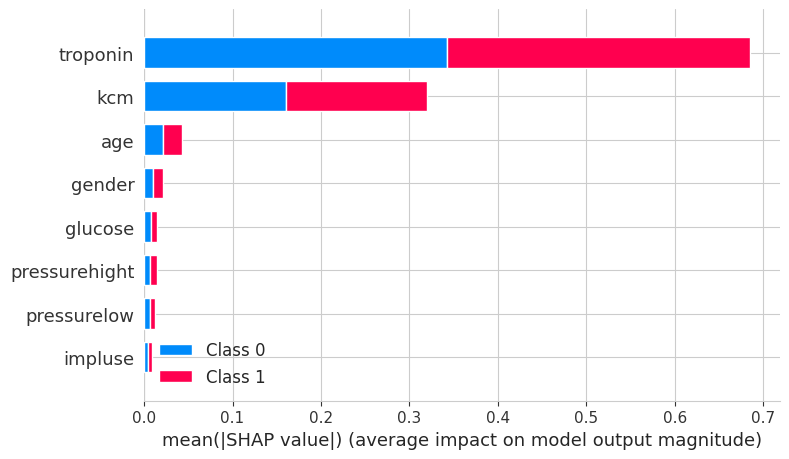

In [ ]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train.values.ravel())
# Creamos el explainer para el RandomForest
explainer = shap.TreeExplainer(clf)

# Calculamos los valores SHAP para todo el conjunto de entrenamiento
shap_values = explainer.shap_values(X_train)

# Visualizamos la importancia de las características para una instancia específica (por ejemplo, el primer registro)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train.iloc[0])

# Para visualizar la importancia promedio de las características en todo el conjunto de datos
shap.summary_plot(shap_values, X_train)

PCA - Visualizar importancia de cada una de las variables

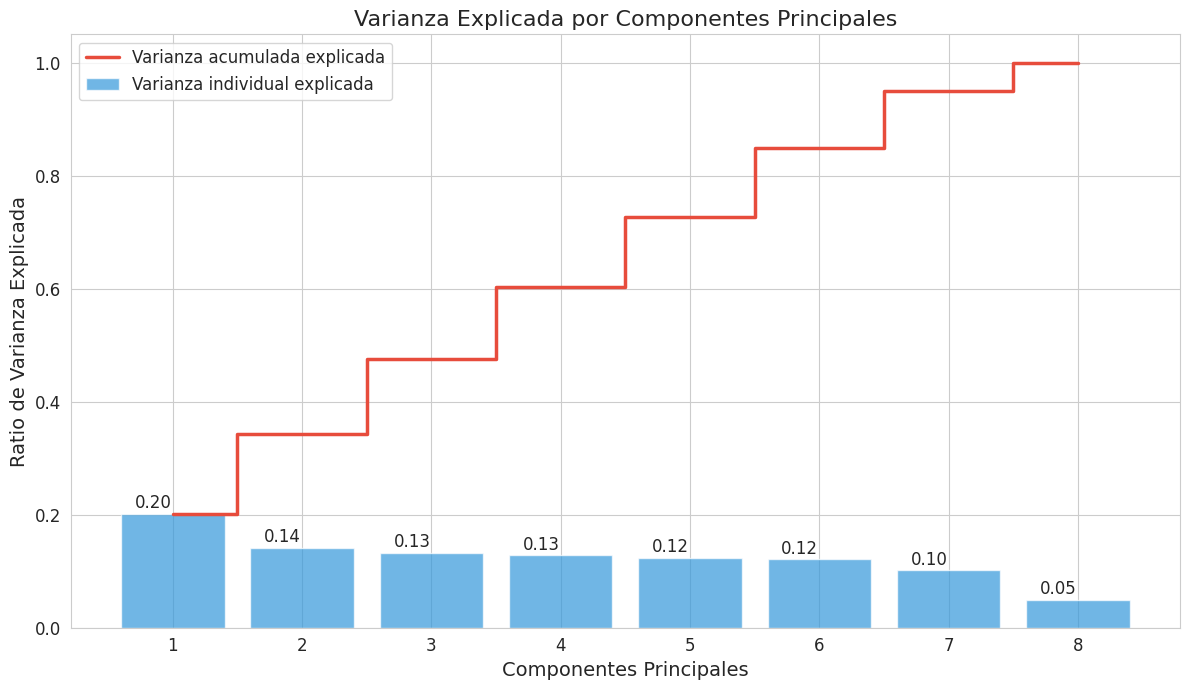

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Establecer el estilo de Seaborn para mejorar la estética
sns.set_style("whitegrid")

features = df.drop('class', axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA()
pca_result = pca.fit_transform(features_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

# Colores personalizados
bar_color = '#3498db' # Azul
line_color = '#e74c3c' # Rojo

plt.figure(figsize=(12,7))
bars = plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center', label='Varianza individual explicada', color=bar_color)
plt.step(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), where='mid', label='Varianza acumulada explicada', color=line_color, linewidth=2.5)
plt.ylabel('Ratio de Varianza Explicada', fontsize=14)
plt.xlabel('Componentes Principales', fontsize=14)
plt.title('Varianza Explicada por Componentes Principales', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Añadir porcentajes encima de cada barra
for bar, value in zip(bars, explained_variance_ratio):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.01, f"{value:.2f}", fontsize=12, ha='center')

plt.tight_layout()
plt.show()


### Elección del mejor dataset

Creamos un DataFrame con todas las interacciones y términos polinómicos posibles. Con este DataFrame, se realizará Forward Selection para obtener las variables que aportan al modelo.

In [ ]:
# Creamos el DataFrame con las interacciones

df_interaccion = df.copy()

df_interaccion["pressure_ratio"] = df_interaccion["pressurehight"] / df_interaccion["pressurelow"]

# Interacciones con la misma variable
df_interaccion["impluse^2"] = df_interaccion["impluse"] ** 2
df_interaccion["pressure_ratio^2"] = df_interaccion["pressure_ratio"] ** 2
df_interaccion["glucose^2"] = df_interaccion["glucose"] ** 2

# Interacciones de las varibles con p-vales BAJOS
df_interaccion["impluse x age"] = df_interaccion["impluse"] * df_interaccion["age"]
df_interaccion["impluse x gender"] = df_interaccion["impluse"] * df_interaccion["gender"]
df_interaccion["impluse x kcm"] = df_interaccion["impluse"] * df_interaccion["kcm"]
df_interaccion["impluse x troponin"] = df_interaccion["impluse"] * df_interaccion["troponin"]
df_interaccion["impluse x pressure_ratio"] = df_interaccion["impluse"] * df_interaccion["pressure_ratio"]
df_interaccion["impluse x glucose"] = df_interaccion["impluse"] * df_interaccion["glucose"]

df_interaccion["pressure_ratio x age"] = df_interaccion["pressure_ratio"] * df_interaccion["age"]
df_interaccion["pressure_ratio x gender"] = df_interaccion["pressure_ratio"] * df_interaccion["gender"]
df_interaccion["pressure_ratio x kcm"] = df_interaccion["pressure_ratio"] * df_interaccion["kcm"]
df_interaccion["pressure_ratio x troponin"] = df_interaccion["pressure_ratio"] * df_interaccion["troponin"]
df_interaccion["pressure_ratio x impluse"] = df_interaccion["pressure_ratio"] * df_interaccion["impluse"]
df_interaccion["pressure_ratio x glucose"] = df_interaccion["pressure_ratio"] * df_interaccion["glucose"]

df_interaccion["glucose x age"] = df_interaccion["glucose"] * df_interaccion["age"]
df_interaccion["glucose x gender"] = df_interaccion["glucose"] * df_interaccion["gender"]
df_interaccion["glucose x kcm"] = df_interaccion["glucose"] * df_interaccion["kcm"]
df_interaccion["glucose x troponin"] = df_interaccion["glucose"] * df_interaccion["troponin"]
df_interaccion["glucose x impluse"] = df_interaccion["glucose"] * df_interaccion["impluse"]
df_interaccion["glucose x pressure_ratio"] = df_interaccion["glucose"] * df_interaccion["pressure_ratio"]

# Interacciones de las varibles con p-vales ALTOS
df_interaccion["age^2"] = df_interaccion["age"] ** 2
# df_interaccion["gender^2"] = df_interaccion["gender"] ** 2
df_interaccion["kcm^2"] = df_interaccion["kcm"] ** 2
df_interaccion["troponin^2"] = df_interaccion["troponin"] ** 2

df_interaccion["age x gender"] = df_interaccion["age"] * df_interaccion["gender"]
df_interaccion["age x kcm"] = df_interaccion["age"] * df_interaccion["kcm"]
df_interaccion["age x troponin"] = df_interaccion["age"] * df_interaccion["troponin"]

df_interaccion["gender x kcm"] = df_interaccion["gender"] * df_interaccion["kcm"]
df_interaccion["gender x troponin"] = df_interaccion["gender"] * df_interaccion["troponin"]

df_interaccion["troponin x kcm"] = df_interaccion["troponin"] * df_interaccion["kcm"]

mover_col = df_interaccion.pop("class")
df_interaccion["class"] = mover_col

df_interaccion.columns

Index(['age', 'gender', 'impluse', 'pressurehight', 'pressurelow', 'glucose',
       'kcm', 'troponin', 'pressure_ratio', 'impluse^2', 'pressure_ratio^2',
       'glucose^2', 'impluse x age', 'impluse x gender', 'impluse x kcm',
       'impluse x troponin', 'impluse x pressure_ratio', 'impluse x glucose',
       'pressure_ratio x age', 'pressure_ratio x gender',
       'pressure_ratio x kcm', 'pressure_ratio x troponin',
       'pressure_ratio x impluse', 'pressure_ratio x glucose', 'glucose x age',
       'glucose x gender', 'glucose x kcm', 'glucose x troponin',
       'glucose x impluse', 'glucose x pressure_ratio', 'age^2', 'kcm^2',
       'troponin^2', 'age x gender', 'age x kcm', 'age x troponin',
       'gender x kcm', 'gender x troponin', 'troponin x kcm', 'class'],
      dtype='object')

In [ ]:
results = []
for col in df_interaccion.columns:
    X = sm.add_constant(df_interaccion[col])  # Agrega una constante (intercepto)
    y = df_interaccion['class']

    model = sm.OLS(y, X).fit()
    p_value = model.pvalues[col]

    results.append({'Variable': col, 'P-Value': p_value})

# Crea un DataFrame con los resultados
p_value_table = pd.DataFrame(results)
p_value_table

,Variable,P-Value
0,age,2.985155e-25
1,gender,7.314583e-15
2,impluse,6.293009e-01
3,pressurehight,1.158260e-01
4,pressurelow,6.734006e-01
5,glucose,8.241345e-02
6,kcm,8.678068e-24
7,troponin,6.246656e-27
8,pressure_ratio,2.653512e-01
9,impluse^2,9.107038e-01


In [ ]:
import statsmodels.api as sm

def forward_selection(data, target):
    initial_features = data.columns.tolist()
    best_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < 0.001:  # Elige tu propio umbral aquí, p.ej. 0.05
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

# Suponiendo que df es tu dataframe y 'class' es tu variable objetivo

target = df_interaccion['class']
data = df_interaccion.drop('class', axis=1)

selected_features = forward_selection(data, target)
print(selected_features)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to 

['troponin', 'troponin^2', 'kcm', 'kcm^2', 'age', 'gender', 'troponin x kcm']


The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Las variables e interacciones más significativas han sido `age`, `kcm`, `kcm^2`, `troponin`, `troponin^2`, `troponin x kcm`, `gender` y `gender^2`. Se crea un DataFrame con solo esas variables, y se utilizará en los modelos que sea conveniente.

In [ ]:
df_bueno = df.copy()

df_bueno["kcm^2"] = df_bueno["kcm"] ** 2
df_bueno["troponin^2"] = df_bueno["troponin"] ** 2
df_bueno["troponin x kcm"] = df_bueno["troponin"] * df_bueno["kcm"]
# df_bueno["gender^2"] = df_bueno["gender"] ** 2

df_bueno.drop(columns="impluse", axis=1, inplace=True)
df_bueno.drop(columns="pressurehight", axis=1, inplace=True)
df_bueno.drop(columns="pressurelow", axis=1, inplace=True)
df_bueno.drop(columns="glucose", axis=1, inplace=True)

mover_col = df_bueno.pop("class")
df_bueno["class"] = mover_col

df_bueno

,age,gender,kcm,troponin,kcm^2,troponin^2,troponin x kcm,class
0,64,1,1.800000,0.012000,3.240000,0.000144,0.021600,0
1,21,1,6.750000,1.060000,45.562500,1.123600,7.155000,1
2,55,1,1.990000,0.003000,3.960100,0.000009,0.005970,0
3,64,1,13.870000,0.122000,192.376900,0.014884,1.692140,1
4,55,1,1.080000,0.003000,1.166400,0.000009,0.003240,0
...,...,...,...,...,...,...,...,...
1615,33,1,1.905094,0.003243,3.629383,0.000011,0.006178,0
1616,29,0,1.392841,0.005859,1.940007,0.000034,0.008161,0
1617,47,0,2.046442,0.007343,4.187926,0.000054,0.015028,0
1618,55,1,1.845257,0.008978,3.404973,0.000081,0.016566,0


In [ ]:
scaler = MinMaxScaler()
df_bueno = pd.DataFrame(scaler.fit_transform(df_bueno), columns=df_bueno.columns)
df_bueno

,age,gender,kcm,troponin,kcm^2,troponin^2,troponin x kcm,class
0,0.561798,1.0,0.004935,0.001068,0.000035,1.347912e-06,0.000029,0.0
1,0.078652,1.0,0.021453,0.102826,0.000505,1.059100e-02,0.010062,1.0
2,0.460674,1.0,0.005569,0.000194,0.000043,7.540767e-08,0.000007,0.0
3,0.561798,1.0,0.045212,0.011749,0.002136,1.402866e-04,0.002379,1.0
4,0.460674,1.0,0.002533,0.000194,0.000012,7.540767e-08,0.000003,0.0
...,...,...,...,...,...,...,...,...
1615,0.213483,1.0,0.005286,0.000218,0.000039,8.970737e-08,0.000007,0.0
1616,0.168539,0.0,0.003577,0.000472,0.000020,3.141816e-07,0.000010,0.0
1617,0.370787,0.0,0.005758,0.000616,0.000045,4.988686e-07,0.000020,0.0
1618,0.460674,1.0,0.005086,0.000775,0.000037,7.503173e-07,0.000022,0.0


In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,0.561798,1.0,0.042163,0.651934,0.387931,0.247036,0.004935,0.001068,0.0
1,0.078652,1.0,0.067828,0.309392,0.068966,0.515810,0.021453,0.102826,1.0
2,0.460674,1.0,0.040330,0.651934,0.336207,0.464427,0.005569,0.000194,0.0
3,0.561798,1.0,0.045830,0.430939,0.146552,0.464427,0.045212,0.011749,1.0
4,0.460674,1.0,0.040330,0.386740,0.232759,0.523715,0.002533,0.000194,0.0
...,...,...,...,...,...,...,...,...,...
1615,0.213483,1.0,0.034830,0.458564,0.267241,0.174818,0.005286,0.000218,0.0
1616,0.168539,0.0,0.082493,0.701657,0.560345,0.067256,0.003577,0.000472,0.0
1617,0.370787,0.0,0.065078,0.447514,0.275862,0.332930,0.005758,0.000616,0.0
1618,0.460674,1.0,0.065995,0.160221,0.465517,0.181029,0.005086,0.000775,0.0


In [ ]:
scaler = MinMaxScaler()
df_no_parametrico = pd.DataFrame(scaler.fit_transform(df_no_parametrico), columns=df_no_parametrico.columns)
df_no_parametrico

,age,gender,kcm,troponin,class
0,0.561798,1.0,0.004935,0.001068,0.0
1,0.078652,1.0,0.021453,0.102826,1.0
2,0.460674,1.0,0.005569,0.000194,0.0
3,0.561798,1.0,0.045212,0.011749,1.0
4,0.460674,1.0,0.002533,0.000194,0.0
...,...,...,...,...,...
1615,0.213483,1.0,0.005286,0.000218,0.0
1616,0.168539,0.0,0.003577,0.000472,0.0
1617,0.370787,0.0,0.005758,0.000616,0.0
1618,0.460674,1.0,0.005086,0.000775,0.0


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Suponiendo que df es tu dataframe y ya has cargado tus datos en él
# df = pd.read_csv('tu_archivo.csv')

# Añadir una constante a los datos (es necesario para calcular el VIF)
df_const = add_constant(df_bueno)

# Calcular VIF para cada característica
vif_data = pd.DataFrame()
vif_data["Variable"] = df_bueno.columns
vif_data["VIF"] = [variance_inflation_factor(df_bueno.values, i) for i in range(df_bueno.shape[1])]

print(vif_data)

# Puedes filtrar las características con un VIF mayor que 5 o 10 según prefieras
high_vif_features = vif_data[vif_data["VIF"] > 5]["Variable"].tolist()
print("Características con alta multicolinealidad:", high_vif_features)

         Variable        VIF
0             age   2.851202
1          gender   2.235619
2             kcm  15.835103
3        troponin   8.080875
4           kcm^2  14.124408
5      troponin^2   6.810223
6  troponin x kcm   1.326380
7           class   2.983322
Características con alta multicolinealidad: ['kcm', 'troponin', 'kcm^2', 'troponin^2']


VIF = 1 es perfecto<br>
VIF entre 1-5 esta bien <br>
VIF mayor que 5 o mayor que 10 (según creamos) signfica multicolinealidad fuerte.

El codo está entorno a 4-5. Es decir, debemos usar 4-5 Componentes Principales.

In [ ]:
# Tabla de los p-valores. No sé si está bien

results = []
for col in df_bueno.columns:
    X = sm.add_constant(df_bueno[col])  # Agrega una constante (intercepto)
    y = df_bueno['class']

    model = sm.OLS(y, X).fit()
    p_value = model.pvalues[col]

    results.append({'Variable': col, 'P-Value': p_value})

# Crea un DataFrame con los resultados
p_value_table = pd.DataFrame(results)
p_value_table

,Variable,P-Value
0,age,2.985155e-25
1,gender,7.314583e-15
2,kcm,8.678068e-24
3,troponin,6.246656e-27
4,kcm^2,6.622890e-12
5,troponin^2,3.715440e-07
6,troponin x kcm,1.066697e-05
7,class,0.000000e+00


DATOS PARA REGRESIÓN LOGÍSTICA

In [ ]:
#########################################################################
#CREACIÓN DE CONJUNTOS (EJECUTAR PARA TODOS LOS MODELOS MENOS LR 1 Y 2) #
#########################################################################


predictores = list(df_bueno.columns[:-1])
X = df_bueno[predictores]
y = df_bueno[['class']]

df_clase_0 = df_bueno[df_bueno['class'] == 0]
df_clase_1 = df_bueno[df_bueno['class'] == 1]

# Particionar cada clase por separado en características y etiquetas
X_0 = df_clase_0.drop('class', axis=1)
Y_0 = df_clase_0['class']

X_1 = df_clase_1.drop('class', axis=1)
Y_1 = df_clase_1['class']

# Hacer el train_test_split para cada clase
X_train_0, X_test_0, Y_train_0, Y_test_0 = train_test_split(X_0, Y_0, test_size=0.20, random_state=42)
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_1, Y_1, test_size=0.20, random_state=42)

# Combinar las particiones de entrenamiento y prueba
X_train = pd.concat([X_train_0, X_train_1])
y_train = pd.concat([Y_train_0, Y_train_1])

X_test = pd.concat([X_test_0, X_test_1])
y_test = pd.concat([Y_test_0, Y_test_1])

# Opcional: Revolver las filas para asegurar aleatoriedad en el conjunto combinado
X_train_LR = X_train.sample(frac=1, random_state=42).reset_index(drop=True)
y_train = y_train.sample(frac=1, random_state=42).reset_index(drop=True)

X_test_LR = X_test.sample(frac=1, random_state=42).reset_index(drop=True)
y_test = y_test.sample(frac=1, random_state=42).reset_index(drop=True)

y_train_LR = y_train.to_frame(name="class")
y_test_LR = y_test.to_frame(name="class")

class_counts = y_train_LR['class'].value_counts()
print(class_counts)

class_counts = y_test_LR['class'].value_counts()
print(class_counts)

0.0    648
1.0    648
Name: class, dtype: int64
0.0    162
1.0    162
Name: class, dtype: int64


DATOS PARA EL RESTO DE MODELOS NO PARAMÉTRICOS

In [ ]:
#########################################################################
#CREACIÓN DE CONJUNTOS (EJECUTAR PARA TODOS LOS MODELOS MENOS LR 1 Y 2) #
#########################################################################


predictores = list(df_no_parametrico.columns[:-1])
X = df_no_parametrico[predictores]
y = df_no_parametrico[['class']]

df_clase_0 = df_no_parametrico[df_no_parametrico['class'] == 0]
df_clase_1 = df_no_parametrico[df_no_parametrico['class'] == 1]

# Particionar cada clase por separado en características y etiquetas
X_0 = df_clase_0.drop('class', axis=1)
Y_0 = df_clase_0['class']

X_1 = df_clase_1.drop('class', axis=1)
Y_1 = df_clase_1['class']

# Hacer el train_test_split para cada clase
X_train_0, X_test_0, Y_train_0, Y_test_0 = train_test_split(X_0, Y_0, test_size=0.20, random_state=42)
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_1, Y_1, test_size=0.20, random_state=42)

# Combinar las particiones de entrenamiento y prueba
X_train = pd.concat([X_train_0, X_train_1])
y_train = pd.concat([Y_train_0, Y_train_1])

X_test = pd.concat([X_test_0, X_test_1])
y_test = pd.concat([Y_test_0, Y_test_1])

# Opcional: Revolver las filas para asegurar aleatoriedad en el conjunto combinado
X_train = X_train.sample(frac=1, random_state=42).reset_index(drop=True)
y_train = y_train.sample(frac=1, random_state=42).reset_index(drop=True)

X_test = X_test.sample(frac=1, random_state=42).reset_index(drop=True)
y_test = y_test.sample(frac=1, random_state=42).reset_index(drop=True)

y_train = y_train.to_frame(name="class")
y_test = y_test.to_frame(name="class")

class_counts = y_train['class'].value_counts()
print(class_counts)

class_counts = y_test['class'].value_counts()
print(class_counts)

0.0    648
1.0    648
Name: class, dtype: int64
0.0    162
1.0    162
Name: class, dtype: int64


In [ ]:
X_train

,age,gender,kcm,troponin,kcm^2,troponin^2,troponin x kcm
1472,0.471910,0.0,0.005659,0.000509,0.000044,3.581328e-07,0.000016
610,0.404494,1.0,0.007438,0.000485,0.000071,3.299086e-07,0.000020
1145,0.730337,0.0,0.003934,0.000485,0.000024,3.299086e-07,0.000011
860,0.449438,1.0,0.008839,0.000583,0.000097,4.524460e-07,0.000028
750,0.741573,0.0,0.010107,0.000874,0.000124,9.331700e-07,0.000046
...,...,...,...,...,...,...,...
118,0.516854,1.0,0.019885,0.009030,0.000437,8.327835e-05,0.000829
183,0.415730,1.0,0.027526,0.000680,0.000815,5.938354e-07,0.000095
446,0.460674,1.0,0.019951,0.000583,0.000440,4.524460e-07,0.000061
715,0.516854,0.0,0.028294,0.001942,0.000859,4.147422e-06,0.000259


## Modelos

### Regresión logística 1

Primero probaremos una regresión logística con todas las variables predictoras. En primera instancia, no se utilizarán las interacciones.

In [ ]:
# Estandarizamos

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# Cambiamos la forma de y desde (1055, 1) a (1055,)
y_train =  y_train.values.ravel()

In [ ]:
modelooooo = LogisticRegression(max_iter=10000)
modelooooo.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [ ]:
y_pred = modelooooo.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Matriz de confusión:\n{conf_matrix}')
print(f'Informe de clasificación:\n{class_report}')

Accuracy: 0.5370370370370371
Matriz de confusión:
[[77 85]
 [65 97]]
Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.54      0.48      0.51       162
         1.0       0.53      0.60      0.56       162

    accuracy                           0.54       324
   macro avg       0.54      0.54      0.54       324
weighted avg       0.54      0.54      0.54       324



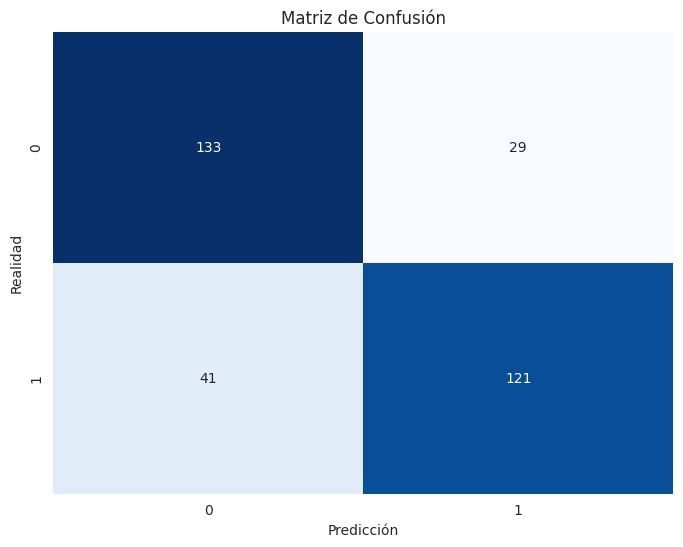

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer el estilo de Seaborn
sns.set_style("whitegrid")

# Gráfico de la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')
plt.show()


### Regresión Logística 2

Ahora probaremos otro modelo de regresión logística, esta vez eliminando las variables predictoras con p-valores grandes. Tampoco se hará uso de las interacciones.

In [ ]:
del_columns = ["impluse", "pressurehight", "pressurelow", "glucose"]    # Columnas a eliminar
df_deleted_cols = df.drop(del_columns, axis=1)

df_deleted_cols

,age,gender,kcm,troponin,class
0,0.561798,1.0,0.004935,0.001068,0.0
1,0.078652,1.0,0.021453,0.102826,1.0
2,0.460674,1.0,0.005569,0.000194,0.0
3,0.561798,1.0,0.045212,0.011749,1.0
4,0.460674,1.0,0.002533,0.000194,0.0
...,...,...,...,...,...
1615,0.213483,1.0,0.005286,0.000218,0.0
1616,0.168539,0.0,0.003577,0.000472,0.0
1617,0.370787,0.0,0.005758,0.000616,0.0
1618,0.460674,1.0,0.005086,0.000775,0.0


In [ ]:
predictores = list(df.columns[:-1])
X = df[predictores]
y = df[['class']]

df_clase_0 = df[df['class'] == 0]
df_clase_1 = df[df['class'] == 1]

# Particionar cada clase por separado en características y etiquetas
X_0 = df_clase_0.drop('class', axis=1)
Y_0 = df_clase_0['class']

X_1 = df_clase_1.drop('class', axis=1)
Y_1 = df_clase_1['class']

# Hacer el train_test_split para cada clase
X_train_0, X_test_0, Y_train_0, Y_test_0 = train_test_split(X_0, Y_0, test_size=0.20, random_state=42)
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_1, Y_1, test_size=0.20, random_state=42)

# Combinar las particiones de entrenamiento y prueba
X_train = pd.concat([X_train_0, X_train_1])
y_train = pd.concat([Y_train_0, Y_train_1])

X_test = pd.concat([X_test_0, X_test_1])
y_test = pd.concat([Y_test_0, Y_test_1])

# Opcional: Revolver las filas para asegurar aleatoriedad en el conjunto combinado
X_train = X_train.sample(frac=1, random_state=42).reset_index(drop=True)
y_train = y_train.sample(frac=1, random_state=42).reset_index(drop=True)

X_test = X_test.sample(frac=1, random_state=42).reset_index(drop=True)
y_test = y_test.sample(frac=1, random_state=42).reset_index(drop=True)

y_train = y_train.to_frame(name="class")
y_test = y_test.to_frame(name="class")

class_counts = y_train['class'].value_counts()
print(class_counts)

class_counts = y_test['class'].value_counts()
print(class_counts)

0.0    648
1.0    648
Name: class, dtype: int64
0.0    162
1.0    162
Name: class, dtype: int64


In [ ]:
# # Estandarizamos

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# Cambiamos la forma de y desde (1055, 1) a (1055,)
y_train =  y_train.values.ravel()

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Matriz de confusión:\n{conf_matrix}')
print(f'Informe de clasificación:\n{class_report}')

Accuracy: 0.7839506172839507
Matriz de confusión:
[[133  29]
 [ 41 121]]
Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.76      0.82      0.79       162
         1.0       0.81      0.75      0.78       162

    accuracy                           0.78       324
   macro avg       0.79      0.78      0.78       324
weighted avg       0.79      0.78      0.78       324



Eliminar las variables predictoras con p-valores altos resulta en un aumento del 0.4% en el accuracy.

El recall muestra el porcentajes de instancias clasificadas correctamente dentro de esa clase. Por ejemplo, el 71% de las instancias con clase 0 han sido predichas correctamente. Esto indica que el 29% corresponde con los falsos negativos. Por otro lado, el recall de la clase 1 es del 85%, lo que indica que 85% de los infartos han sido clasificados correctamente. Esto indica que hay un 15% de falsos negativos.

Los falsos negativos tienen un impacto más severo que los falsos postiivos. Es por esto que, sería necesario reducir el umbral de decisión para que P(Y=1|X) sea más probable que P(Y=0|X).


### Regresión Logística con interacciones

Vamos a meter interacción de las variables con p-valores altos consigo mismas y con las demás para ver si pueden aportar algo al modelo.

Ahora quitamos las variables e interacciones que tienen p-valores altos, y volvemos a calcular los p-valores a ver si tenemos que volver a quitar alguna

In [ ]:
# Se genera la tabla de p-valores de las variables que se van a utilizar.

results = []
for col in df_bueno.columns:
    X = sm.add_constant(df_bueno[col])
    y = df_bueno['class']

    model = sm.OLS(y, X).fit()
    p_value = model.pvalues[col]

    results.append({'Variable': col, 'P-Value': p_value})

# Crea un DataFrame con los resultados
p_value_table = pd.DataFrame(results)
p_value_table

,Variable,P-Value
0,age,2.985155e-25
1,gender,7.314583e-15
2,kcm,8.678068e-24
3,troponin,6.246656e-27
4,kcm^2,6.622890e-12
5,troponin^2,3.715440e-07
6,troponin x kcm,1.066697e-05
7,gender^2,7.314583e-15
8,class,0.000000e+00


Ahora todos los p-valores son chiquitos. Vamos a entrenar otro modelo con estas variables e interacciones

In [ ]:
# Cambiamos la forma de y desde (1055, 1) a (1055,)
y_train_LR =  y_train_LR.values.ravel()

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_LR, y_train_LR)

LogisticRegression(max_iter=10000)

In [ ]:
# Se obtienen las probabilidades de la clase 1
y_prob = model.predict_proba(X_test_LR)[:, 1]

In [ ]:
# Se clasifican como 1 solo las instancias que tengan probabilidad mayor al umbral
umbral = 0.5
y_pred = (y_prob > umbral).astype(int)

In [ ]:
accuracy = accuracy_score(y_test_LR, y_pred)
conf_matrix = confusion_matrix(y_test_LR, y_pred)
class_report = classification_report(y_test_LR, y_pred)

print(f'Precisión: {accuracy}')
print(f'Matriz de confusión:\n{conf_matrix}')
print(f'Informe de clasificación:\n{class_report}')

Precisión: 0.7438271604938271
Matriz de confusión:
[[128  34]
 [ 49 113]]
Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.72      0.79      0.76       162
         1.0       0.77      0.70      0.73       162

    accuracy                           0.74       324
   macro avg       0.75      0.74      0.74       324
weighted avg       0.75      0.74      0.74       324



### Regresión Logística con umbral más bajo

In [ ]:
# # Estandarizamos

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# Cambiamos la forma de y desde (1055, 1) a (1055,)
y_train =  y_train.values.ravel()

AttributeError: ignored

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [ ]:
# Se obtienen las probabilidades de la clase 1
y_prob = model.predict_proba(X_test)[:, 1]

In [ ]:
# Se clasifican como 1 solo las instancias que tengan probabilidad mayor al umbral
umbral = 0.4
y_pred = (y_prob > umbral).astype(int)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Precisión: {accuracy}')
print(f'Matriz de confusión:\n{conf_matrix}')
print(f'Informe de clasificación:\n{class_report}')

Precisión: 0.5
Matriz de confusión:
[[  1 161]
 [  1 161]]
Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.50      0.01      0.01       162
         1.0       0.50      0.99      0.67       162

    accuracy                           0.50       324
   macro avg       0.50      0.50      0.34       324
weighted avg       0.50      0.50      0.34       324



### LDA (o QDA)

In [ ]:
# # Estandarizamos

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
lda = QuadraticDiscriminantAnalysis()
lda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [ ]:
y_pred = lda.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Precisión: {accuracy}')
print(f'Matriz de confusión:\n{conf_matrix}')
print(f'Informe de clasificación:\n{class_report}')

Precisión: 0.7561728395061729
Matriz de confusión:
[[162   0]
 [ 79  83]]
Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80       162
         1.0       1.00      0.51      0.68       162

    accuracy                           0.76       324
   macro avg       0.84      0.76      0.74       324
weighted avg       0.84      0.76      0.74       324



Buena precisión en general pero mal recall para la clase 1. Necesitamos un buen recall para esta clase

### RandomForest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=1, max_features="sqrt")
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=1, random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Precisión: {accuracy}')
print(f'Matriz de confusión:\n{conf_matrix}')
print(f'Informe de clasificación:\n{class_report}')

Precisión: 0.9938271604938271
Matriz de confusión:
[[162   0]
 [  2 160]]
Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       162
         1.0       1.00      0.99      0.99       162

    accuracy                           0.99       324
   macro avg       0.99      0.99      0.99       324
weighted avg       0.99      0.99      0.99       324



### KNN

In [ ]:
####################
### ESTANDARIZAR ###
####################

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Setting 'n_neighbors' to 5 as an example. This value can be tuned.
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predicting on test data
y_pred = knn.predict(X_test)

# Evaluating the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Imprimir las puntuaciones de validación cruzada

Accuracy: 0.8333333333333334

Confusion Matrix:
 [[151  11]
 [ 43 119]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.93      0.85       162
         1.0       0.92      0.73      0.82       162

    accuracy                           0.83       324
   macro avg       0.85      0.83      0.83       324
weighted avg       0.85      0.83      0.83       324



### Pruebas con Cross-validation

In [ ]:
qda = QuadraticDiscriminantAnalysis()

# Configurar la validación cruzada con 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Realizar validación cruzada y obtener las puntuaciones
scores = cross_val_score(modelooooo, X, y, cv=kf)

# Imprimir las puntuaciones de validación cruzada
print("Puntuaciones de Validación Cruzada (5 folds):", scores)
print("Precisión media:", scores.mean())

Puntuaciones de Validación Cruzada (5 folds): [0.75       0.75308642 0.71604938 0.7345679  0.73148148]
Precisión media: 0.737037037037037


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [ ]:
# Train XGBoost classifier
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)


# Predict
y_pred_xgb = model_xgb.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(f'Matriz de confusión:\n{conf_matrix}')
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))# Initializing KNN classifier


XGBoost Accuracy: 0.9969135802469136
Matriz de confusión:
[[162   0]
 [  1 161]]

XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       162
         1.0       1.00      0.99      1.00       162

    accuracy                           1.00       324
   macro avg       1.00      1.00      1.00       324
weighted avg       1.00      1.00      1.00       324



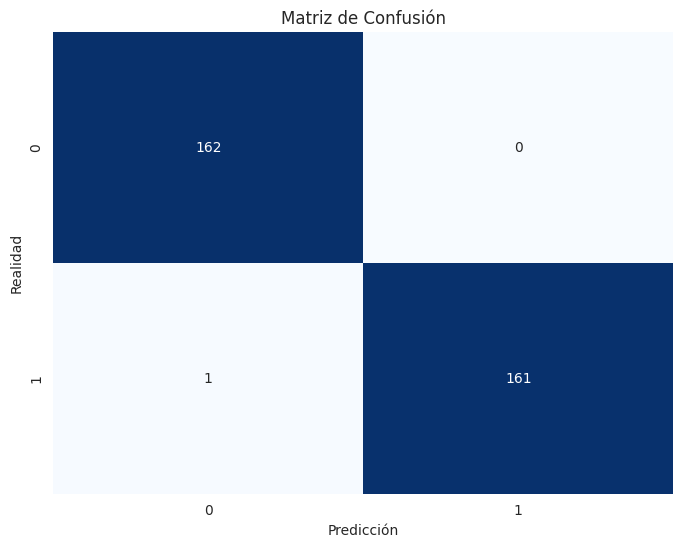

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer el estilo de Seaborn
sns.set_style("whitegrid")

# Gráfico de la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')
plt.show()

### LIGHTGBM

In [ ]:
# Define parameters (this is a basic set; LightGBM has a lot of tunable parameters)
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, X_train, num_round)

# Predict
y_pred_lgb = bst.predict(X_test, num_iteration=bst.best_iteration)
# Convert probabilities to binary outputs
y_pred_lgb_binary = [1 if p > 0.5 else 0 for p in y_pred_lgb]

# Evaluate
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb_binary))
print("\nLightGBM Classification Report:\n", classification_report(y_test, y_pred_lgb_binary))

TypeError: ignored

### MLP

In [ ]:
predictores = list(df_interaccion.columns[:-1])
X = df_interaccion[predictores]
y = df_interaccion[['class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(32, 64, 128), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(32, 64, 128), max_iter=300, random_state=42)

In [ ]:
y_pred = mlp_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Precisión: {accuracy}')
print(f'Matriz de confusión:\n{conf_matrix}')
print(f'Informe de clasificación:\n{class_report}')

Precisión: 0.8209876543209876
Matriz de confusión:
[[155   7]
 [ 51 111]]
Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.75      0.96      0.84       162
         1.0       0.94      0.69      0.79       162

    accuracy                           0.82       324
   macro avg       0.85      0.82      0.82       324
weighted avg       0.85      0.82      0.82       324



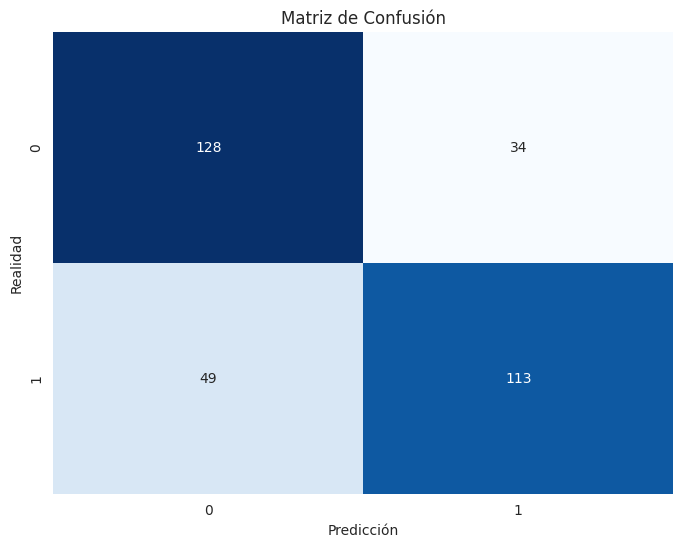

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer el estilo de Seaborn
sns.set_style("whitegrid")

# Gráfico de la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')
plt.show()

### Bagging

In [ ]:
# 1. Bagging
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred = bagging_model.predict(X_test)
print(f"Accuracy de Bagging: {accuracy_score(y_test, y_pred)}")

# 2. Boosting
boosting_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
boosting_model.fit(X_train, y_train)
y_pred = boosting_model.predict(X_test)
print(f"Accuracy de Boosting: {accuracy_score(y_test, y_pred)}")

# 3. Stacking
estimators = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
print(f"Accuracy de Stacking: {accuracy_score(y_test, y_pred)}")

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Accuracy de Bagging: 0.9969135802469136
Accuracy de Boosting: 0.9907407407407407


`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Accuracy de Stacking: 0.7685185185185185


In [ ]:
# Cargamos el conjunto de datos
javi = df.copy()
javi

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,0.561798,1.0,0.042163,0.651934,0.387931,0.247036,0.004935,0.001068,0.0
1,0.078652,1.0,0.067828,0.309392,0.068966,0.515810,0.021453,0.102826,1.0
2,0.460674,1.0,0.040330,0.651934,0.336207,0.464427,0.005569,0.000194,0.0
3,0.561798,1.0,0.045830,0.430939,0.146552,0.464427,0.045212,0.011749,1.0
4,0.460674,1.0,0.040330,0.386740,0.232759,0.523715,0.002533,0.000194,0.0
...,...,...,...,...,...,...,...,...,...
1615,0.213483,1.0,0.034830,0.458564,0.267241,0.174818,0.005286,0.000218,0.0
1616,0.168539,0.0,0.082493,0.701657,0.560345,0.067256,0.003577,0.000472,0.0
1617,0.370787,0.0,0.065078,0.447514,0.275862,0.332930,0.005758,0.000616,0.0
1618,0.460674,1.0,0.065995,0.160221,0.465517,0.181029,0.005086,0.000775,0.0


In [ ]:
del_columns = ["age", "gender" , "impluse", "pressurehight", "pressurelow", "glucose", "kcm"]
javi.drop(del_columns, axis=1, inplace=True)

javi

,troponin,class
0,0.001068,0.0
1,0.102826,1.0
2,0.000194,0.0
3,0.011749,1.0
4,0.000194,0.0
...,...,...
1615,0.000218,0.0
1616,0.000472,0.0
1617,0.000616,0.0
1618,0.000775,0.0


In [ ]:
# p-valores

# Tabla de los p-valores.

results = []
for col in javi.columns:
    X = sm.add_constant(javi[col])  # Agrega una constante (intercepto)
    y = javi['class']

    model = sm.OLS(y, X).fit()
    p_value = model.pvalues[col]

    results.append({'Variable': col, 'P-Value': p_value})

# Crea un DataFrame con los resultados
p_value_table = pd.DataFrame(results)
p_value_table

,Variable,P-Value
0,troponin,6.246656e-27
1,class,0.000000e+00


In [ ]:
del_columns = ["impluse", "pressurehight", "pressurelow"]
javi.drop(del_columns, axis=1, inplace=True)

In [ ]:
javi

,age,gender,impluse,pressurehight,pressurelow,glucose,class
0,0.561798,1.0,0.042163,0.651934,0.387931,0.247036,0.0
1,0.078652,1.0,0.067828,0.309392,0.068966,0.515810,1.0
2,0.460674,1.0,0.040330,0.651934,0.336207,0.464427,0.0
3,0.561798,1.0,0.045830,0.430939,0.146552,0.464427,1.0
4,0.460674,1.0,0.040330,0.386740,0.232759,0.523715,0.0
...,...,...,...,...,...,...,...
1615,0.213483,1.0,0.034830,0.458564,0.267241,0.174818,0.0
1616,0.168539,0.0,0.082493,0.701657,0.560345,0.067256,0.0
1617,0.370787,0.0,0.065078,0.447514,0.275862,0.332930,0.0
1618,0.460674,1.0,0.065995,0.160221,0.465517,0.181029,0.0


In [ ]:
#########################################################################
#CREACIÓN DE CONJUNTOS (EJECUTAR PARA TODOS LOS MODELOS MENOS LR 1 Y 2) #
#########################################################################


predictores = list(javi.columns[:-1])
X = javi[predictores]
y = javi[['class']]

df_clase_0 = javi[javi['class'] == 0]
df_clase_1 = javi[javi['class'] == 1]

# Particionar cada clase por separado en características y etiquetas
X_0 = df_clase_0.drop('class', axis=1)
Y_0 = df_clase_0['class']

X_1 = df_clase_1.drop('class', axis=1)
Y_1 = df_clase_1['class']

# Hacer el train_test_split para cada clase
X_train_0, X_test_0, Y_train_0, Y_test_0 = train_test_split(X_0, Y_0, test_size=0.20, random_state=42)
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_1, Y_1, test_size=0.20, random_state=42)

# Combinar las particiones de entrenamiento y prueba
X_train = pd.concat([X_train_0, X_train_1])
y_train = pd.concat([Y_train_0, Y_train_1])

X_test = pd.concat([X_test_0, X_test_1])
y_test = pd.concat([Y_test_0, Y_test_1])

# Opcional: Revolver las filas para asegurar aleatoriedad en el conjunto combinado
X_train = X_train.sample(frac=1, random_state=42).reset_index(drop=True)
y_train = y_train.sample(frac=1, random_state=42).reset_index(drop=True)

X_test = X_test.sample(frac=1, random_state=42).reset_index(drop=True)
y_test = y_test.sample(frac=1, random_state=42).reset_index(drop=True)

y_train = y_train.to_frame(name="class")
y_test = y_test.to_frame(name="class")

class_counts = y_train['class'].value_counts()
print(class_counts)

class_counts = y_test['class'].value_counts()
print(class_counts)

0.0    648
1.0    648
Name: class, dtype: int64
0.0    162
1.0    162
Name: class, dtype: int64


In [ ]:
y_train =  y_train.values.ravel()

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [ ]:
# Se obtienen las probabilidades de la clase 1
y_prob = model.predict_proba(X_test)[:, 1]

In [ ]:
# Se clasifican como 1 solo las instancias que tengan probabilidad mayor al umbral
umbral = 0.5
y_pred = (y_prob > umbral).astype(int)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Precisión: {accuracy}')
print(f'Matriz de confusión:\n{conf_matrix}')
print(f'Informe de clasificación:\n{class_report}')

Precisión: 0.7407407407407407
Matriz de confusión:
[[162   0]
 [ 84  78]]
Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.66      1.00      0.79       162
         1.0       1.00      0.48      0.65       162

    accuracy                           0.74       324
   macro avg       0.83      0.74      0.72       324
weighted avg       0.83      0.74      0.72       324



In [ ]:
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=100, max_features="sqrt")
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, n_estimators=300, random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Precisión: {accuracy}')
print(f'Matriz de confusión:\n{conf_matrix}')
print(f'Informe de clasificación:\n{class_report}')

Precisión: 0.9104938271604939
Matriz de confusión:
[[162   0]
 [ 29 133]]
Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       162
         1.0       1.00      0.82      0.90       162

    accuracy                           0.91       324
   macro avg       0.92      0.91      0.91       324
weighted avg       0.92      0.91      0.91       324



In [ ]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [ ]:
y_pred = qda.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Precisión: {accuracy}')
print(f'Matriz de confusión:\n{conf_matrix}')
print(f'Informe de clasificación:\n{class_report}')

Precisión: 0.6820987654320988
Matriz de confusión:
[[128  34]
 [ 69  93]]
Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.65      0.79      0.71       162
         1.0       0.73      0.57      0.64       162

    accuracy                           0.68       324
   macro avg       0.69      0.68      0.68       324
weighted avg       0.69      0.68      0.68       324



In [ ]:
####################
### ESTANDARIZAR ###
####################

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Setting 'n_neighbors' to 5 as an example. This value can be tuned.
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predicting on test data
y_pred = knn.predict(X_test)

# Evaluating the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Imprimir las puntuaciones de validación cruzada

Accuracy: 0.7253086419753086

Confusion Matrix:
 [[126  36]
 [ 53 109]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.78      0.74       162
         1.0       0.75      0.67      0.71       162

    accuracy                           0.73       324
   macro avg       0.73      0.73      0.72       324
weighted avg       0.73      0.73      0.72       324



In [ ]:
# Train XGBoost classifier
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))# Initializing KNN classifier


XGBoost Accuracy: 0.7006172839506173

XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.73      0.71       162
         1.0       0.71      0.67      0.69       162

    accuracy                           0.70       324
   macro avg       0.70      0.70      0.70       324
weighted avg       0.70      0.70      0.70       324



In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(32, 64, 128), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(32, 64, 128), max_iter=1000, random_state=42)

In [ ]:
y_pred = mlp_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Precisión: {accuracy}')
print(f'Matriz de confusión:\n{conf_matrix}')
print(f'Informe de clasificación:\n{class_report}')

Precisión: 0.6820987654320988
Matriz de confusión:
[[124  38]
 [ 65  97]]
Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.66      0.77      0.71       162
         1.0       0.72      0.60      0.65       162

    accuracy                           0.68       324
   macro avg       0.69      0.68      0.68       324
weighted avg       0.69      0.68      0.68       324

